# Non-Abelian Gauge Fields in Parameter-Space of Spin-1 System

In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

In [2]:
#----- Global Settings -----
sx, sy, sz = qt.operators.jmat(1, 'x'), qt.operators.jmat(1, 'y'), qt.operators.jmat(1, 'z') #Shorthand spin matrices

#--- Projection Operators ---
p1, p2, p3 = qt.basis(3,0).proj(), qt.basis(3,1).proj(), qt.basis(3,2).proj() #Project onto bare spins (z-basis)
eigx, eigy = sx.eigenstates(), sy.eigenstates() #eigenstates of sx, sy
px1, px2, px3 = eigx[1][0].proj(), eigx[1][1].proj(), eigx[1][2].proj() #Corresponding proj. ops.
py1, py2, py3 = eigy[1][0].proj(), eigy[1][1].proj(), eigy[1][2].proj() #Corresponding proj. ops.

proj_ops = [p1, p2, p3, px1, px2, px3, py1, py2, py3] #All ops. in list

In [3]:
def hamiltonian(t, args):
    ''' Returns the Hamiltonian for qt.sesolve() '''
    
    Omega0 = args['Omega0'] #Rabi freq.
    delta = args['delta'] #Detuning
    
    #----- Time-Dependent Operators -----
    CX = 2*Omega0*sx #Sigma-x coupling term coefficient
    CY = 2*Omega0*sy #Sigma-y coupling term coefficient
    D = 2*delta*sz #Detuning term coefficient
    
    def CX_t(t, args):
        ''' Time-dependent part of CX '''
        w = args['floq_f'] #Floquet freq.
        Theta = args['Theta'] #Theta loop parameter
        Phi = args['Phi'] #Phi loop parameter
        return np.cos(w*t)*np.sin(Theta*t)*np.sin(Phi[0]*t + Phi[1])
    
    def CY_t(t, args):
        ''' Time-dependent part of CY '''
        w = args['floq_f'] #Floquet freq.
        Theta = args['Theta'] #Theta loop parameter
        Phi = args['Phi'] #Phi loop parameter
        return np.cos(w*t)*np.sin(Theta*t)*np.cos(Phi[0]*t + Phi[1])

    def D_t(t, args):
        ''' Time-dependent coefficient of H1 '''
        w = args['floq_f'] #Floquet freq.
        Theta = args['Theta'] #Theta loop parameter
        return np.cos(w*t)*np.cos(Theta*t)

    #--- Solve SE ---
    H = [ [CX, CX_t], [CY, CY_t], [D, D_t] ] #Full Hamiltonian for func.-based approach
    
    return H

def loop(psi, t, args, proj_ops=None):
    ''' Numerically simulate a single loop in param. space '''
    
    H = hamiltonian(t, args) #Hamiltonian
    Psi = qt.sesolve(H, psi, t, e_ops=proj_ops, args=args) #Solve TDSE
    return Psi

def path(order, Thetas, Phis, psi0, out='states', proj_ops=[]):
    ''' Evolution over consecutive paths defined by elements of Theta & Phi '''
    
    #--- Compute Evolution Over Loops ---
    psi_in = psi0 #Initial input state
    psis = [] #Empty list for output states
    exps = np.empty( (len(proj_ops),0) ) #Empty array for exp vals
    
    for i in order:
        args['Theta'] = Thetas[i] #Theta param for loop
        args['Phi'] = Phis[i] #Phi param for loop
        
        psi_out = loop(psi_in, t, args) #Compute states through loop
        
        #Unpack result
        if out=='states':
            for s in psi_out.states:
                psis.append(s) #Add state to list
        elif out=='exp':
            psi_exp = loop(psi_in, t, args, proj_ops=proj_ops) #Compute exp vals through loop
            e_array = np.array([e for e in psi_exp.expect]) #As row-like array
            exps = np.hstack( (exps, e_array) ) #Stack results
        
        psi_in = psi_out.states[-1] #Set new initial state
        
    t_ax = np.hstack( (t, t+t[-1], t+2*t[-1]) ) #Stack times together for combined axis
        
    if out=='states':
        return psis, t_ax
    elif out=='exp':
        return exps, t_ax
    

In [4]:
#----- Global Operator Settings -----
Omega0 = 1 #Rabi freq.
n_cyc = 10 #Number of Rabi oscillations per op.

#--- Computed ---
delta = Omega0 #Detuning
slow_f = (1/n_cyc)*Omega0 #Adiabatic freq.
floq_f = 2*Omega0 #Floquet freq.

args = {'Omega0':Omega0, 'delta':delta, 'slow_f':slow_f, 'floq_f':floq_f} #Parameter list

#--- Loop Parameters ---
Thetas = [slow_f, slow_f, slow_f] #Theta params for 3 loops
Phis = [ [0,0], [0,np.pi/2], [slow_f,0] ] #Phi params for 3 loops

t = np.linspace(0, 2*np.pi/slow_f, num=1000) #Time axis for a single loop

#----- Compute Evolution -----
psi0 = qt.basis(3,0) #Initial State
psi0 = psi0.unit() #Force normalization

path1, path2 = [0, 1, 2], [0, 2, 1] #Indices for differnet loop orders

#--- States ---
states1, t1 = path( path1, Thetas, Phis, psi0, out='states')
states2, t2 = path( path2, Thetas, Phis, psi0, out='states')

print( f'Overlap of psi1 & psi2: {states1[-1].overlap(states2[-1]):.4f}' )

#--- Time-Evolution of Exp. Vals ---
ans1, t1 = path( path1, Thetas, Phis, psi0, out='exp', proj_ops=proj_ops )
ans2, t2 = path( path2, Thetas, Phis, psi0, out='exp', proj_ops=proj_ops )

Overlap of psi1 & psi2: 0.8580+0.1567j


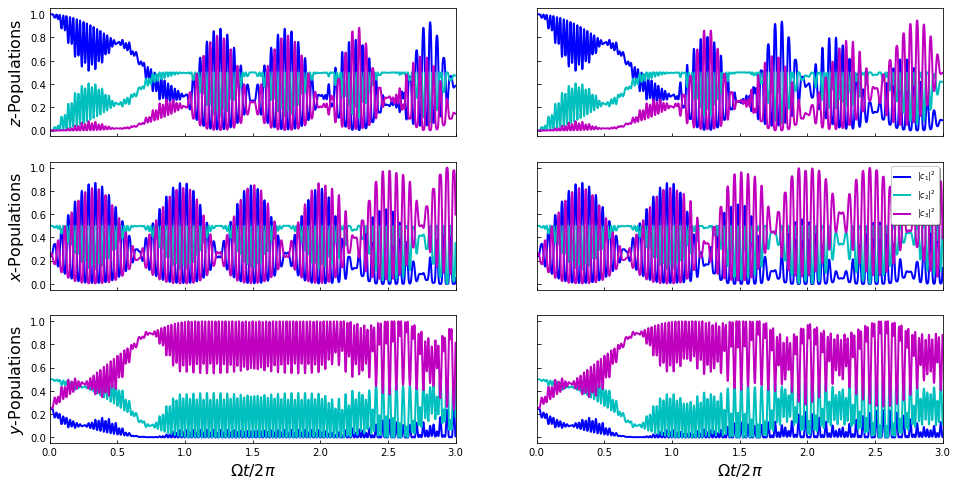

In [5]:
def draw_pops(ax, t, arrs, labels):
    ''' Plots 3 passed populations on given figure axis '''
    
    lines = ['b-', 'c-', 'm-'] #Linestyles for 3 plots
    for i, data in enumerate(arrs):
        ax.plot( t*(slow_f/2/np.pi), data, lines[i], lw=2, label=labels[i])

#----- Plot Results -----
fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(16,8) )
fs = 16 #Label fontsize
labels = ['$|c_{1}|^2$', '$|c_{2}|^2$', '$|c_{3}|^2$'] #Plot labels

#--- Draw Plots ---
draw_pops( ax[0,0], t1, [ans1[0], ans1[1], ans1[2]], labels )
draw_pops( ax[0,1], t2, [ans2[0], ans2[1], ans2[2]], labels )

draw_pops( ax[1,0], t1, [ans1[3], ans1[4], ans1[5]], labels )
draw_pops( ax[1,1], t2, [ans2[3], ans2[4], ans2[5]], labels )

draw_pops( ax[2,0], t1, [ans1[6], ans1[7], ans1[8]], labels )
draw_pops( ax[2,1], t2, [ans2[6], ans2[7], ans2[8]], labels )

#--- Plot Settings ---
for a in ax[2,0], ax[2,1]:
    a.set_xlabel('$\Omega t/2\pi$', fontsize=fs) #Comman x-label
ax[0,0].set_ylabel('$z$-Populations', fontsize=fs)
ax[1,0].set_ylabel('$x$-Populations', fontsize=fs)
ax[2,0].set_ylabel('$y$-Populations', fontsize=fs)

ax[1,1].legend(loc='best', fancybox=True, shadow=True, framealpha=1, fontsize=8)
for ax in ax[0,0], ax[1,0], ax[2,0], ax[0,1], ax[1,1], ax[2,1]:
    ax.set_xlim([0,3]) #Remove extra spaces at ends
    ax.tick_params(direction='in') #Set grid-ticks inward
plt.show()

## Comparison with Floquet Theory

In [30]:
from scipy.special import j0

#----- Evolution Operator -----
g = (1/2) * ( j0(2*Omega0/floq_f) -1 ) #Phase factor
Phi = Phis[0][1]
U_fl = ( (-1j*2*np.pi*g) * (-1*np.sin(Phi)*sx + np.cos(Phi)*sy) ).expm()

#--- Numerical ---
args['Theta'], args['Phi'] = Thetas[0], Phis[0]
psi = loop(psi0, t, args)

print( U_fl )
print( U_fl * psi0, psi.states[-1] )

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[ 0.87002446  0.47556681  0.12997554]
 [-0.47556681  0.74004893  0.47556681]
 [ 0.12997554 -0.47556681  0.87002446]]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.87002446]
 [-0.47556681]
 [ 0.12997554]] Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.54540239-4.45269499e-02j]
 [ 0.02865959+7.03402857e-01j]
 [-0.45272137+4.81196659e-07j]]
